In [1]:
!pip install -q flwr[simulation] flwr-datasets[vision] torch torchvision matplotlib

In [2]:
from collections import OrderedDict
from typing import List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from datasets.utils.logging import disable_progress_bar
from torch.utils.data import DataLoader

import flwr
from flwr.client import Client, ClientApp, NumPyClient
from flwr.common import Metrics, Context
from flwr.server import ServerApp, ServerConfig, ServerAppComponents
from flwr.server.strategy import FedAvg
from flwr.simulation import run_simulation
from flwr_datasets import FederatedDataset

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Training on {DEVICE}")
print(f"Flower {flwr.__version__} / PyTorch {torch.__version__}")
disable_progress_bar()

Training on cpu
Flower 1.18.0 / PyTorch 2.6.0+cu124


In [3]:
NUM_CLIENTS = 10
BATCH_SIZE = 32


def load_datasets(partition_id: int):
    fds = FederatedDataset(dataset="cifar10", partitioners={"train": NUM_CLIENTS})
    partition = fds.load_partition(partition_id)
    # Divide data on each node: 80% train, 20% test
    partition_train_test = partition.train_test_split(test_size=0.2, seed=42)
    pytorch_transforms = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )

    def apply_transforms(batch):
        # Instead of passing transforms to CIFAR10(..., transform=transform)
        # we will use this function to dataset.with_transform(apply_transforms)
        # The transforms object is exactly the same
        batch["img"] = [pytorch_transforms(img) for img in batch["img"]]
        return batch

    # Create train/val for each partition and wrap it into DataLoader
    partition_train_test = partition_train_test.with_transform(apply_transforms)
    trainloader = DataLoader(
        partition_train_test["train"], batch_size=BATCH_SIZE, shuffle=True
    )
    valloader = DataLoader(partition_train_test["test"], batch_size=BATCH_SIZE)
    testset = fds.load_split("test").with_transform(apply_transforms)
    testloader = DataLoader(testset, batch_size=BATCH_SIZE)
    return trainloader, valloader, testloader

In [4]:
# Get a single batch from the trainloader
trainloader, valloader, testloader = load_datasets(partition_id=0)  # Assuming partition_id=0

# Get one batch and print
batch = next(iter(trainloader))  # Retrieve first batch
print(batch.keys())  # Check available keys
# print(batch["img"].shape)  # Check tensor shape
# print(batch)  # View entire batch contents

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


dict_keys(['img', 'label'])


In [5]:
print(batch['img'].shape)

torch.Size([32, 3, 32, 32])


32 → The batch size (you specified BATCH_SIZE = 32 earlier). This means there are 32 images in this batch.

3 → The number of color channels (RGB). Since the images are in color, there are 3 channels: Red, Green, and Blue.

32 → The height of each image (CIFAR-10 images are 32x32 pixels).

32 → The width of each image (same as above, 32x32 pixels).


Each batch consists of 32 images, and each image has 3 color channels, with a resolution of 32x32 pixels.


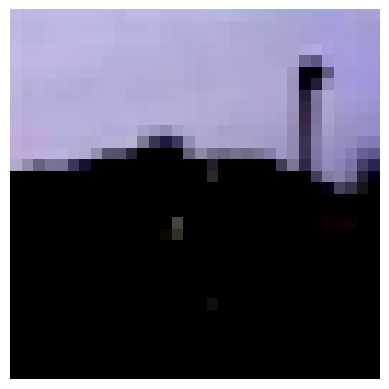

In [6]:
# Convert tensor image to numpy format for visualization
image_tensor = batch["img"][0]  # Take the first image from batch
image_numpy = image_tensor.permute(1, 2, 0).cpu().numpy()  # Rearrange dimensions for display

plt.imshow(image_numpy)
plt.axis("off")
plt.show()

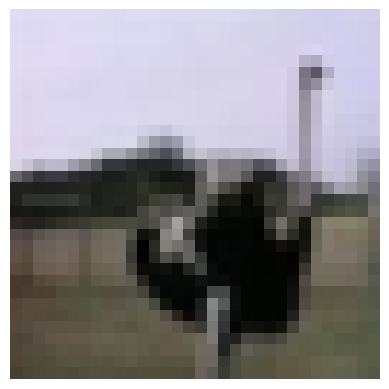

In [7]:
# Convert tensor image to numpy format
image_tensor = batch["img"][0]  # Take the first image
image_numpy = image_tensor.permute(1, 2, 0).cpu().numpy()  # Rearrange dimensions

# Undo normalization completely (restore pixel values to 0-255 range)
image_numpy = (image_numpy * 0.5 + 0.5) * 255  # Reverse transformation
image_numpy = image_numpy.astype("uint8")  # Convert to unsigned 8-bit integers

plt.imshow(image_numpy)
plt.axis("off")
plt.show()

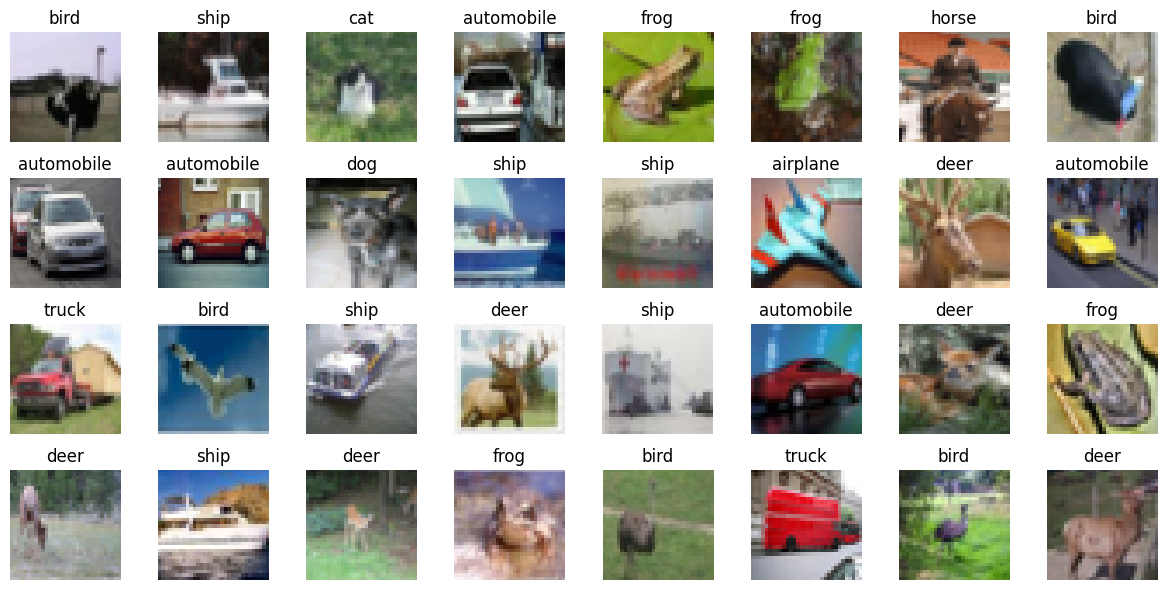

In [8]:
trainloader, _, _ = load_datasets(partition_id=0)
# batch = next(iter(trainloader))
images, labels = batch["img"], batch["label"]

# Reshape and convert images to a NumPy array
# matplotlib requires images with the shape (height, width, 3)
images = images.permute(0, 2, 3, 1).numpy()

# Denormalize
images = images / 2 + 0.5

# Create a figure and a grid of subplots
fig, axs = plt.subplots(4, 8, figsize=(12, 6))

# Loop over the images and plot them
for i, ax in enumerate(axs.flat):
    ax.imshow(images[i])
    ax.set_title(trainloader.dataset.features["label"].int2str([labels[i]])[0])
    ax.axis("off")

# Show the plot
fig.tight_layout()
plt.show()

## Step 1: Centralized Training with PyTorch






In [9]:
class Net(nn.Module):
    def __init__(self) -> None:
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

First convolution (conv1)

Takes 3 channels (RGB) as input (CIFAR-10 images).

Uses 6 filters, each of size 5x5 pixels.

Second convolution (conv2)

Takes 6 feature maps (output of conv1).

Uses 16 filters, each of size 5x5 pixels.

MaxPool2d(kernel_size=2, stride=2) reduces the image size by half.

This improves efficiency and reduces unnecessary information.

fc1: Takes flattened feature maps (16 channels of size 5×5) and connects 120 neurons.

fc2: Connects 120 neurons to 84 neurons.

fc3: Final output layer; 10 neurons represent 10 classes (CIFAR-10 classification)

Converts the 3D feature maps into a 1D vector for the fully connected layers.

view(-1, 16 * 5 * 5) reshapes it into 400 neurons.

After flattening, the data passes through three fully connected layers.

The final layer (fc3) does NOT use ReLU because it outputs raw class scores (logits).



In [10]:
def train(net, trainloader, epochs: int, verbose=False):

    """
    net: Your CNN model (an instance of Net).
    trainloader: The DataLoader that provides batches of training data.
    epochs: The number of iterations to train over the dataset.
    verbose: If True, prints loss and accuracy during training.

    """

    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())

    """
    criterion → Defines Cross-Entropy Loss,
    commonly used for classification tasks.
    It measures how well predictions match actual labels.

    optimizer → Uses the Adam optimizer,
    which adjusts model weights using gradient descent.

    """



    net.train()
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0


        """
        - correct → Tracks how many predictions are correct.
        - total → Counts total samples.
        - epoch_loss → Stores total loss for the epoch.

        """

        for batch in trainloader:
            images, labels = batch["img"].to(DEVICE), batch["label"].to(DEVICE)

            """

            Retrieves images and labels from the batch and moves them to the correct device (CPU or GPU).

            """


            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels)


            """

            Forward pass → Sends images through the CNN to get predictions (outputs).
            Loss computation → Compares predictions (outputs) with actual labels

            """

            loss.backward()
            optimizer.step()

            """

            - zero_grad() → Clears previous gradients.
            - backward() → Computes gradients based on loss.
            - step() → Updates model weights.

            """




            # Metrics
            epoch_loss += loss
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()


            """

            torch.max(outputs.data, 1)[1] → Extracts predicted class labels.
            Normalizes loss over the dataset.
            Computes accuracy by dividing correct predictions by total samples.

            """


        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total


        """

        Normalizes loss over the dataset.
        Computes accuracy by dividing correct predictions by total samples.

        """



        if verbose:
            print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")





def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for batch in testloader:
            images, labels = batch["img"].to(DEVICE), batch["label"].to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

In [11]:
trainloader, valloader, testloader = load_datasets(partition_id=0)
net = Net().to(DEVICE)

for epoch in range(5):
    train(net, trainloader, 1)
    loss, accuracy = test(net, valloader)
    print(f"Epoch {epoch+1}: validation loss {loss}, accuracy {accuracy}")

loss, accuracy = test(net, testloader)
print(f"Final test set performance:\n\tloss {loss}\n\taccuracy {accuracy}")

Epoch 1: validation loss 0.060191027164459225, accuracy 0.306
Epoch 2: validation loss 0.05405406630039215, accuracy 0.397
Epoch 3: validation loss 0.05333887398242951, accuracy 0.379
Epoch 4: validation loss 0.051431353688240054, accuracy 0.407
Epoch 5: validation loss 0.049585564136505125, accuracy 0.436
Final test set performance:
	loss 0.049564581382274625
	accuracy 0.4142


In [12]:
for name, param in net.state_dict().items():
    print(f"{name}: {param.shape}")

conv1.weight: torch.Size([6, 3, 5, 5])
conv1.bias: torch.Size([6])
conv2.weight: torch.Size([16, 6, 5, 5])
conv2.bias: torch.Size([16])
fc1.weight: torch.Size([120, 400])
fc1.bias: torch.Size([120])
fc2.weight: torch.Size([84, 120])
fc2.bias: torch.Size([84])
fc3.weight: torch.Size([10, 84])
fc3.bias: torch.Size([10])


In [13]:
for name, param in net.state_dict().items():
    print(f"{name}:\n{param}\n")

conv1.weight:
tensor([[[[-0.0493,  0.0906,  0.1145,  0.0287,  0.0244],
          [-0.0182,  0.0946,  0.0039, -0.0643, -0.0590],
          [ 0.0509,  0.0437,  0.0031,  0.0188, -0.1076],
          [ 0.0957,  0.0741,  0.1146, -0.0416, -0.0275],
          [-0.0018,  0.0214,  0.0699,  0.0497,  0.0339]],

         [[ 0.0419,  0.1354, -0.0478,  0.0099, -0.1367],
          [ 0.0912,  0.1025,  0.1351, -0.0876, -0.1380],
          [ 0.0033, -0.0432,  0.1635,  0.0383, -0.1219],
          [-0.0741, -0.0192,  0.0377,  0.0504, -0.1434],
          [ 0.0322,  0.1428, -0.0721,  0.0170, -0.0439]],

         [[ 0.0471,  0.0278,  0.0047, -0.0383, -0.0415],
          [-0.0625,  0.0413,  0.0078,  0.1117,  0.0118],
          [ 0.0802,  0.0442,  0.0293,  0.0551, -0.0306],
          [ 0.0212,  0.0355,  0.1220,  0.0688, -0.0321],
          [ 0.0554,  0.0672,  0.0908,  0.0028,  0.0784]]],


        [[[-0.0186, -0.1601, -0.1114, -0.1152, -0.1472],
          [-0.1007, -0.1881, -0.1173, -0.0027,  0.0624],
         

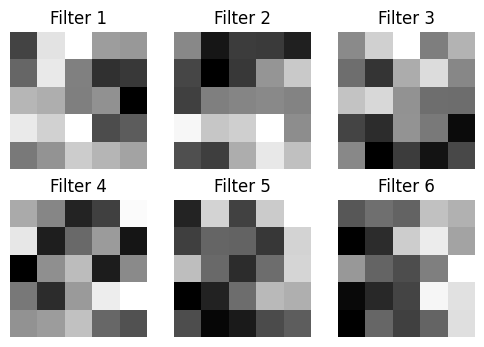

In [14]:
import matplotlib.pyplot as plt

weights = net.conv1.weight.cpu().detach().numpy()  # Convert tensor to NumPy
fig, axs = plt.subplots(2, 3, figsize=(6, 4))  # 6 filters in conv1

for i, ax in enumerate(axs.flat):
    ax.imshow(weights[i, 0], cmap="gray")  # Show first channel of each filter
    ax.axis("off")
    ax.set_title(f"Filter {i+1}")

plt.show()

## Step 2: Federated Learning with Flower

In [16]:
def set_parameters(net, parameters: List[np.ndarray]):
    """
    Updates the model (net) with new parameters received from federated learning clients.
    net: The PyTorch model.
    parameters: A list of NumPy arrays containing updated weights from different clients.
    """

    params_dict = zip(net.state_dict().keys(), parameters)
    """
    Pairs each layer name (net.state_dict().keys())
    with its corresponding new parameter values (parameters).
    """

    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    """
    Converts each NumPy array (v) into a PyTorch tensor (torch.Tensor(v)).
    Stores them in an OrderedDict, keeping the structure intact.
    """

    net.load_state_dict(state_dict, strict=True)
    """
    Loads the updated parameters into the model.
    strict=True ensures every key matches the model’s architecture.
    """


def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

These functions are actually general utility functions used on both the server and client sides

Server-side usage:

get_parameters to extract parameters from the global model to send to clients

set_parameters to update the global model with aggregated parameters

Client-side usage:

set_parameters to initialize the local model with parameters received from the server

get_parameters to extract updated parameters after local training to send back to the server





### Define the Flower ClientApp

With that out of the way, let's move on to the interesting part. Federated learning systems consist of a server and multiple clients. In Flower, we create a `ServerApp` and a `ClientApp` to run the server-side and client-side code, respectively.

The first step toward creating a `ClientApp` is to implement a subclasses of `flwr.client.Client` or `flwr.client.NumPyClient`. We use `NumPyClient` in this tutorial because it is easier to implement and requires us to write less boilerplate. To implement `NumPyClient`, we create a subclass that implements the three methods `get_parameters`, `fit`, and `evaluate`:

* `get_parameters`: Return the current local model parameters
* `fit`: Receive model parameters from the server, train the model on the local data, and return the updated model parameters to the server
* `evaluate`: Receive model parameters from the server, evaluate the model on the local data, and return the evaluation result to the server

We mentioned that our clients will use the previously defined PyTorch components for model training and evaluation. Let's see a simple Flower client implementation that brings everything together:

In [17]:
class FlowerClient(NumPyClient):
    def __init__(self, net, trainloader, valloader):
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        return get_parameters(self.net)

    def fit(self, parameters, config):
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader, epochs=1)
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}

Our class `FlowerClient` defines how local training/evaluation will be performed and allows Flower to call the local training/evaluation through `fit` and `evaluate`. Each instance of `FlowerClient` represents a *single client* in our federated learning system. Federated learning systems have multiple clients (otherwise, there's not much to federate), so each client will be represented by its own instance of `FlowerClient`. If we have, for example, three clients in our workload, then we'd have three instances of `FlowerClient` (one on each of the machines we'd start the client on). Flower calls `FlowerClient.fit` on the respective instance when the server selects a particular client for training (and `FlowerClient.evaluate` for evaluation).

In this notebook, we want to simulate a federated learning system with 10 clients *on a single machine*. This means that the server and all 10 clients will live on a single machine and share resources such as CPU, GPU, and memory. Having 10 clients would mean having 10 instances of `FlowerClient` in memory. Doing this on a single machine can quickly exhaust the available memory resources, even if only a subset of these clients participates in a single round of federated learning.

In addition to the regular capabilities where server and clients run on multiple machines, Flower, therefore, provides special simulation capabilities that create `FlowerClient` instances only when they are actually necessary for training or evaluation. To enable the Flower framework to create clients when necessary, we need to implement a function that creates a `FlowerClient` instance on demand. We typically call this function `client_fn`. Flower calls `client_fn` whenever it needs an instance of one particular client to call `fit` or `evaluate` (those instances are usually discarded after use, so they should not keep any local state). In federated learning experiments using Flower, clients are identified by a partition ID, or `partition-id`. This `partition-id` is used to load different local data partitions for different clients, as can be seen below. The value of `partition-id` is retrieved from the `node_config` dictionary in the `Context` object, which holds the information that persists throughout each training round.

With this, we have the class `FlowerClient` which defines client-side training/evaluation and `client_fn` which allows Flower to create `FlowerClient` instances whenever it needs to call `fit` or `evaluate` on one particular client. Last, but definitely not least, we create an instance of `ClientApp` and pass it the `client_fn`. `ClientApp` is the entrypoint that a running Flower client uses to call your code (as defined in, for example, `FlowerClient.fit`).

In [18]:
def client_fn(context: Context) -> Client:
    """Create a Flower client representing a single organization."""

    # Load model
    net = Net().to(DEVICE)

    # Load data (CIFAR-10)
    # Note: each client gets a different trainloader/valloader, so each client
    # will train and evaluate on their own unique data partition
    # Read the node_config to fetch data partition associated to this node
    partition_id = context.node_config["partition-id"]
    trainloader, valloader, _ = load_datasets(partition_id=partition_id)

    # Create a single Flower client representing a single organization
    # FlowerClient is a subclass of NumPyClient, so we need to call .to_client()
    # to convert it to a subclass of `flwr.client.Client`
    return FlowerClient(net, trainloader, valloader).to_client()


# Create the ClientApp
client = ClientApp(client_fn=client_fn)

### Define the Flower ServerApp

On the server side, we need to configure a strategy which encapsulates the federated learning approach/algorithm, for example, *Federated Averaging* (FedAvg). Flower has a number of built-in strategies, but we can also use our own strategy implementations to customize nearly all aspects of the federated learning approach. For this example, we use the built-in `FedAvg` implementation and customize it using a few basic parameters:

In [19]:
# Create FedAvg strategy
strategy = FedAvg(
    fraction_fit=1.0,  # Sample 100% of available clients for training
    fraction_evaluate=0.5,  # Sample 50% of available clients for evaluation
    min_fit_clients=10,  # Never sample less than 10 clients for training
    min_evaluate_clients=5,  # Never sample less than 5 clients for evaluation
    min_available_clients=10,  # Wait until all 10 clients are available
)

Similar to `ClientApp`, we create a `ServerApp` using a utility function `server_fn`. In `server_fn`, we pass an instance of `ServerConfig` for defining the number of federated learning rounds (`num_rounds`) and we also pass the previously created `strategy`. The `server_fn` returns a `ServerAppComponents` object containing the settings that define the `ServerApp` behaviour. `ServerApp` is the entrypoint that Flower uses to call all your server-side code (for example, the strategy).

In [20]:
def server_fn(context: Context) -> ServerAppComponents:
    """Construct components that set the ServerApp behaviour.

    You can use the settings in `context.run_config` to parameterize the
    construction of all elements (e.g the strategy or the number of rounds)
    wrapped in the returned ServerAppComponents object.
    """

    # Configure the server for 5 rounds of training
    config = ServerConfig(num_rounds=5)

    return ServerAppComponents(strategy=strategy, config=config)


# Create the ServerApp
server = ServerApp(server_fn=server_fn)

### Run the training

In simulation, we often want to control the amount of resources each client can use. In the next cell, we specify a `backend_config` dictionary with the `client_resources` key (required) for defining the amount of CPU and GPU resources each client can access.

In [21]:
# Specify the resources each of your clients need
# By default, each client will be allocated 1x CPU and 0x GPUs
backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 0.0}}

# When running on GPU, assign an entire GPU for each client
if DEVICE == "cuda":
    backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 1.0}}
    # Refer to our Flower framework documentation for more details about Flower simulations
    # and how to set up the `backend_config`

The last step is the actual call to `run_simulation` which - you guessed it - runs the simulation. `run_simulation` accepts a number of arguments:
- `server_app` and `client_app`: the previously created `ServerApp` and `ClientApp` objects, respectively
- `num_supernodes`: the number of `SuperNodes` to simulate which equals the number of clients for Flower simulation
- `backend_config`: the resource allocation used in this simulation

In [22]:
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
    verbose_logging=True,  # Enable verbose logging
)

DEBUG 2025-05-02 09:41:38,580:     Asyncio event loop already running.
DEBUG:flwr:Asyncio event loop already running.
DEBUG 2025-05-02 09:41:38,585:     Logger propagate set to False
DEBUG 2025-05-02 09:41:38,586:     Pre-registering run with id 15856416116675772695
DEBUG 2025-05-02 09:41:38,587:     Using InMemoryState
DEBUG 2025-05-02 09:41:38,590:     Using InMemoryState
INFO 2025-05-02 09:41:38,593:      Starting Flower ServerApp, config: num_rounds=5, no round_timeout
INFO 2025-05-02 09:41:38,596:      
DEBUG 2025-05-02 09:41:38,597:     Using InMemoryState
INFO 2025-05-02 09:41:38,602:      [INIT]
DEBUG 2025-05-02 09:41:38,602:     Registered 10 nodes
DEBUG 2025-05-02 09:41:38,604:     Supported backends: ['ray']
DEBUG 2025-05-02 09:41:38,606:     Initialising: RayBackend
INFO 2025-05-02 09:41:38,604:      Requesting initial parameters from one random client
DEBUG 2025-05-02 09:41:38,607:     Backend config: {'client_resources': {'num_cpus': 1, 'num_gpus': 0.0}, 'init_args': {}, 

### Behind the scenes

So how does this work? How does Flower execute this simulation?

When we call `run_simulation`, we tell Flower that there are 10 clients (`num_supernodes=10`, where 1 `SuperNode` launches 1 `ClientApp`). Flower then goes ahead an asks the `ServerApp` to issue an instructions to those nodes using the `FedAvg` strategy. `FedAvg` knows that it should select 100% of the available clients (`fraction_fit=1.0`), so it goes ahead and selects 10 random clients (i.e., 100% of 10).

Flower then asks the selected 10 clients to train the model. Each of the 10 `ClientApp` instances receives a message, which causes it to call `client_fn` to create an instance of `FlowerClient`. It then calls `.fit()` on each the `FlowerClient` instances and returns the resulting model parameter updates to the `ServerApp`. When the `ServerApp` receives the model parameter updates from the clients, it hands those updates over to the strategy (*FedAvg*) for aggregation. The strategy aggregates those updates and returns the new global model, which then gets used in the next round of federated learning.

In [23]:
# prompt: i want to access the global model parameters

# Access global model parameters after training
for name, param in net.state_dict().items():
    print(f"{name}: {param.shape}")

# Access and print the values of global model parameters
for name, param in net.state_dict().items():
    print(f"{name}:\n{param}\n")


conv1.weight: torch.Size([6, 3, 5, 5])
conv1.bias: torch.Size([6])
conv2.weight: torch.Size([16, 6, 5, 5])
conv2.bias: torch.Size([16])
fc1.weight: torch.Size([120, 400])
fc1.bias: torch.Size([120])
fc2.weight: torch.Size([84, 120])
fc2.bias: torch.Size([84])
fc3.weight: torch.Size([10, 84])
fc3.bias: torch.Size([10])
conv1.weight:
tensor([[[[-0.0493,  0.0906,  0.1145,  0.0287,  0.0244],
          [-0.0182,  0.0946,  0.0039, -0.0643, -0.0590],
          [ 0.0509,  0.0437,  0.0031,  0.0188, -0.1076],
          [ 0.0957,  0.0741,  0.1146, -0.0416, -0.0275],
          [-0.0018,  0.0214,  0.0699,  0.0497,  0.0339]],

         [[ 0.0419,  0.1354, -0.0478,  0.0099, -0.1367],
          [ 0.0912,  0.1025,  0.1351, -0.0876, -0.1380],
          [ 0.0033, -0.0432,  0.1635,  0.0383, -0.1219],
          [-0.0741, -0.0192,  0.0377,  0.0504, -0.1434],
          [ 0.0322,  0.1428, -0.0721,  0.0170, -0.0439]],

         [[ 0.0471,  0.0278,  0.0047, -0.0383, -0.0415],
          [-0.0625,  0.0413,  0.007